# 1. 환경 설정

In [1]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.layers import BatchNormalization

# 랜덤 시드 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  

# 2. 데이터셋 준비

In [2]:
# CIFAR10 이미지 데이터셋
from tensorflow.keras import datasets
cifar10 = datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 피처 스케일링
X_train = X_train / 255.
X_test = X_test / 255.

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


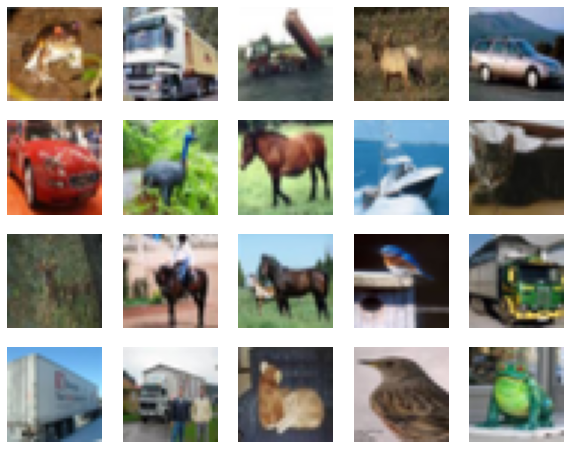

In [ ]:
# Train 이미지 출력하기
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1), 
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

# 3. 모델 구축

In [ ]:
def build_cnn():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2),
                     activation='relu', input_shape=[32, 32, 3]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])

    return model

cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 64)          256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

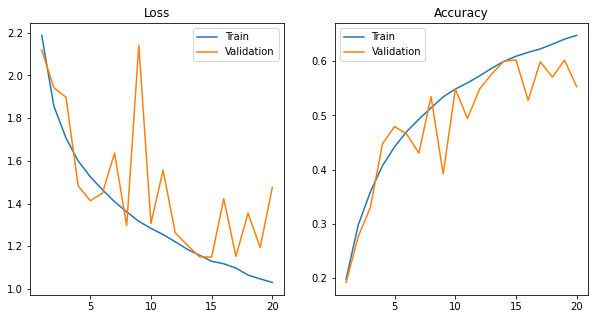

In [ ]:
# 모델 학습
cnn_history = cnn_model.fit(X_train, y_train, batch_size=256, epochs=20,
                        validation_split=0.1, verbose=0) 

# 20 epoch 까지 손실함수와 정확도를 그래프로 나타내는 함수

def plot_metrics(history, start=1, end=20):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Loss: 손실 함수
    axes[0].plot(range(start, end+1), history.history['loss'][start-1:end], 
                label='Train')
    axes[0].plot(range(start, end+1), history.history['val_loss'][start-1:end], 
                label='Validation')
    axes[0].set_title('Loss')
    axes[0].legend()
    # Accuraccy: 예측 정확도
    axes[1].plot(range(start, end+1), history.history['accuracy'][start-1:end], 
                label='Train')
    axes[1].plot(range(start, end+1), history.history['val_accuracy'][start-1:end], 
                label='Validation')
    axes[1].set_title('Accuracy')
    axes[1].legend()
plt.show()

# 그래프 그리기
plot_metrics(history=cnn_history, start=1, end=20)    

# 4. 전이 학습

In [ ]:
# Pre-trained 모델 가져오기 (VGG16)
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=[32, 32, 3],classes=10)  

In [ ]:
# Transfer 모델 생성
def build_transfer():
    transfer_model = Sequential()
    transfer_model.add(cnn_base) 
    transfer_model.add(Flatten()) 

    transfer_model.add(Dense(units=64, activation='relu'))
    transfer_model.add(Dropout(rate=0.5))
    transfer_model.add(Dense(units=32, activation='relu'))
    transfer_model.add(Dropout(rate=0.5))
    transfer_model.add(Dense(units=10, activation='softmax'))

    transfer_model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])


    return transfer_model

transfer_model = build_transfer()
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

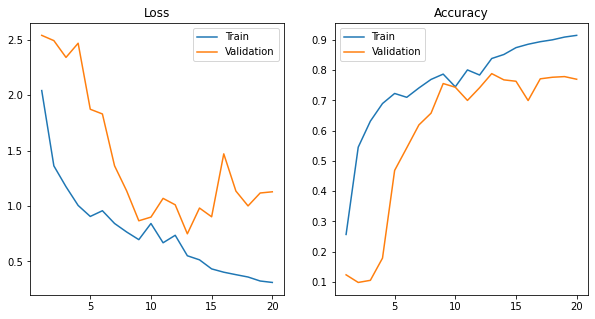

In [ ]:
tm_history = transfer_model.fit(X_train, y_train, batch_size=256, epochs=20,
                        validation_split=0.1, verbose=0) 

plot_metrics(history=tm_history, start=1, end=20)   